In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [105]:
data=pd.read_csv('/content/customers.csv')
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [106]:
data=data.drop('ID',axis=1)
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [107]:
data.fillna({"Work_Experience": 0,"Family_Size": data["Family_Size"].median()},inplace=True)

In [108]:
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])

In [109]:
x = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [110]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [111]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [112]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.fc1 = torch.nn.Linear(size, 32)
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 4)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [113]:
x_train.shape[1]

9

In [114]:
cynthia_brain=NeuralNetwork(x_train.shape[1])
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(cynthia_brain.parameters(),lr=0.001)

In [115]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [116]:
train_model(cynthia_brain, train_loader, loss_fn, optimizer, epochs=50)

Epoch [10/50], Loss: 1.1477
Epoch [20/50], Loss: 1.0191
Epoch [30/50], Loss: 1.2814
Epoch [40/50], Loss: 1.1947
Epoch [50/50], Loss: 0.7831


In [117]:
cynthia_brain.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = cynthia_brain(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [118]:
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=target_encoder.classes_)
print("Name: Cynthia Mehul J")
print("Register No: 212223240020")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name: Cynthia Mehul J
Register No: 212223240020
Test Accuracy: 0.47%
Confusion Matrix:
 [[267  93 104 120]
 [156 136 129  69]
 [ 97  69 254  52]
 [171  28  36 358]]
Classification Report:
               precision    recall  f1-score   support

           A       0.39      0.46      0.42       584
           B       0.42      0.28      0.33       490
           C       0.49      0.54      0.51       472
           D       0.60      0.60      0.60       593

    accuracy                           0.47      2139
   macro avg       0.47      0.47      0.47      2139
weighted avg       0.47      0.47      0.47      2139



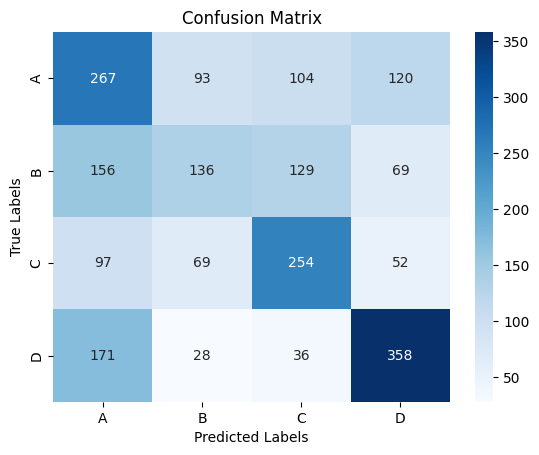

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [121]:
sample_input = x_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = cynthia_brain(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = target_encoder.inverse_transform([predicted_class_index])[0]
print("Name: Cynthia Mehul J")
print("Register No: 212223240020")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {target_encoder.inverse_transform([y_test[12].item()])[0]}')

Name: Cynthia Mehul J
Register No: 212223240020
Predicted class for sample input: D
Actual class for sample input: D
